# General Hugging Face Analysis

This script contains the analysis for the general Hugging Face analysis for the 'What is the Carbon Footprint of ML Models on
Hugging Face? A Repository Mining Study' paper. The analysis can be replicated by executing the cells in order, please make sure the dataset referenced in read_df_processed function is in the corresponding directory.

In [2]:
import time
import pandas as pd
import numpy as np
import re
import Levenshtein
import ast
import matplotlib.pyplot as plt
import yaml

from huggingface_hub import HfApi
from huggingface_hub import ModelSearchArguments, DatasetSearchArguments, ModelCard
from huggingface_hub import hf_hub_url, get_hf_file_metadata
from difflib import SequenceMatcher

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib

pd.options.mode.chained_assignment = None

/home/joel/.envs/TFG/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
width_in = 252/72.27

def set_size(width_pt, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to sit nicely in our document.

    Parameters
    ----------
    width_pt: float
            Document width in points
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])
    
    return (fig_width_in, fig_height_in)


In [4]:
def read_df_processed():
    df = pd.read_csv('../../datasets/HFTotalProcessed.csv')
    df = df.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)
    df['library_name'] = df['library_name'].apply(lambda libraries:  ast.literal_eval(libraries) if not isinstance(libraries, list) else libraries)
    df['datasets'] = df['datasets'].apply(lambda datasets: [''] if pd.isnull(datasets) else [datasets] if '[' not in datasets else ast.literal_eval(datasets))

    return df

df = read_df_processed()

latex = False

if latex:
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })

/tmp/ipykernel_23512/1227418081.py:2: DtypeWarning: Columns (6,7,8,9,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../datasets/HFTotalProcessed.csv')


### Evolution of models popularity - is HF gaining popularity?

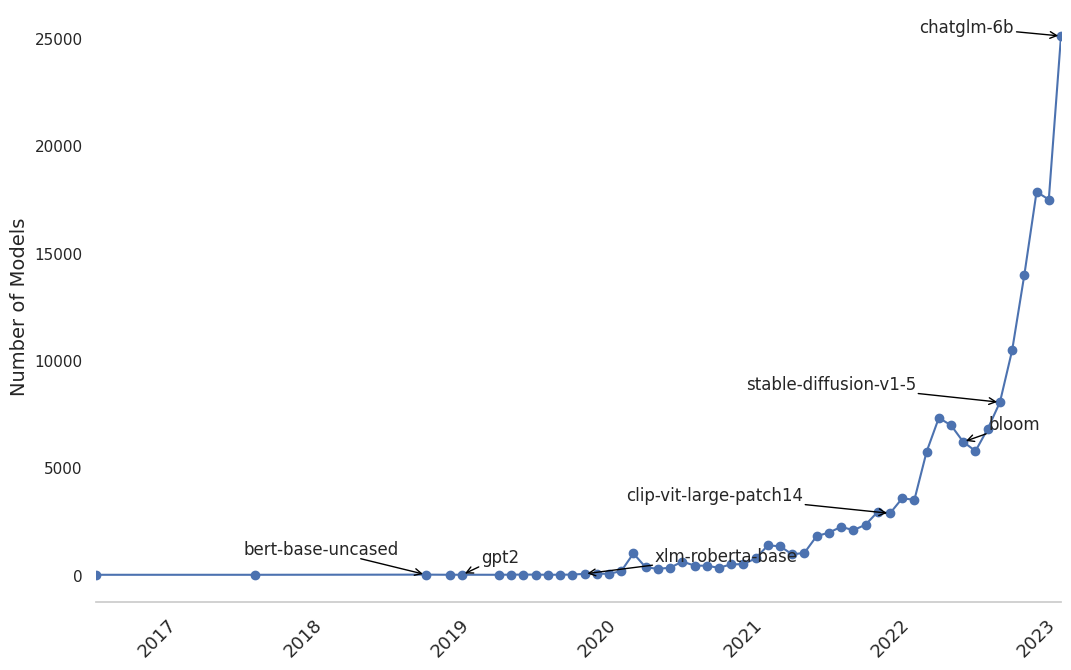

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from adjustText import adjust_text

df['created_at'] = pd.to_datetime(df['created_at']).dt.tz_localize(None)
monthly_counts = df['created_at'].groupby(df['created_at'].dt.to_period('M')).count()

sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=set_size(900)) #antes 516

monthly_counts_except_last = monthly_counts.iloc[:-1]
monthly_counts_except_last.plot(ax=ax, marker='o', linestyle='-')
ax.set_xlabel(None)
ax.set_ylabel('Number of Models', fontsize=14)
# ax.set_title('Evolution of Total Number of Models per Month')
plt.xticks(rotation=45, fontsize=13)
plt.grid()

sns.despine(left=True, bottom=False) 

# Adding labels of desired_models
desired_models = ['bert-base-uncased', 'gpt2', 'chatglm-6b', 'stable-diffusion-v1-5', 'bloom', 'xlm-roberta-base', 'clip-vit-large-patch14']
texts = []
for model in desired_models:
    row = df[df['modelId'] == model].iloc[0]
    model_name = row['modelId']
    downloads = row['downloads']
    x, y = row['created_at'], monthly_counts[row['created_at'].to_period('M')]
    texts.append(ax.text(x, y, model_name, fontsize=12))

# Adjust the text labels to minimize overlaps
adjust_text(texts, expand_points=(2, 2), expand_text=(1.7, 1.7), arrowprops=dict(arrowstyle='->', lw=1, color='black'), ax=ax)

plt.savefig('huggingface_evolution.pdf', bbox_inches='tight')
plt.show()


### Frameworks analysis

In [9]:
df = read_df_processed()

/tmp/ipykernel_33175/1227418081.py:2: DtypeWarning: Columns (6,7,8,9,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../datasets/HFTotalProcessed.csv')


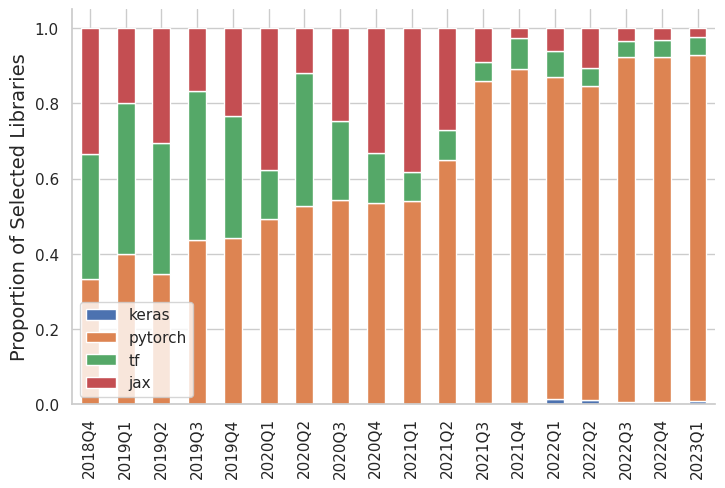

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a column for each specified library in the DataFrame
libraries = ['keras', 'pytorch', 'tf', 'jax']
for library in libraries:
    df[library] = df['library_name'].apply(lambda x: library in x)


    
# Group the DataFrame by a suitable time period (e.g., month or quarter) and calculate the count of each library in each group
df['period'] = pd.to_datetime(df['created_at']).dt.to_period('Q')
library_counts = df.groupby('period')[libraries].sum()

# Normalize the counts to get proportions
library_proportions = library_counts.div(library_counts.sum(axis=1), axis=0)[2:-1]



sns.set(style='whitegrid')

if latex:
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })

# 4. Plot the stacked bar chart
ax = library_proportions.plot(kind='bar', stacked=True, figsize=set_size(600))
ax.set_ylabel('Proportion of Selected Libraries', fontsize=14)
# ax.set_title('Evolution of Selected Libraries Proportions Every 3 Months')
ax.set_xlabel(None)

plt.savefig('frameworks_evolution.pdf', bbox_inches='tight')
sns.despine()
plt.show()


### Tags analysis

In [11]:
df = read_df_processed()

/tmp/ipykernel_33175/1227418081.py:2: DtypeWarning: Columns (6,7,8,9,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../datasets/HFTotalProcessed.csv')


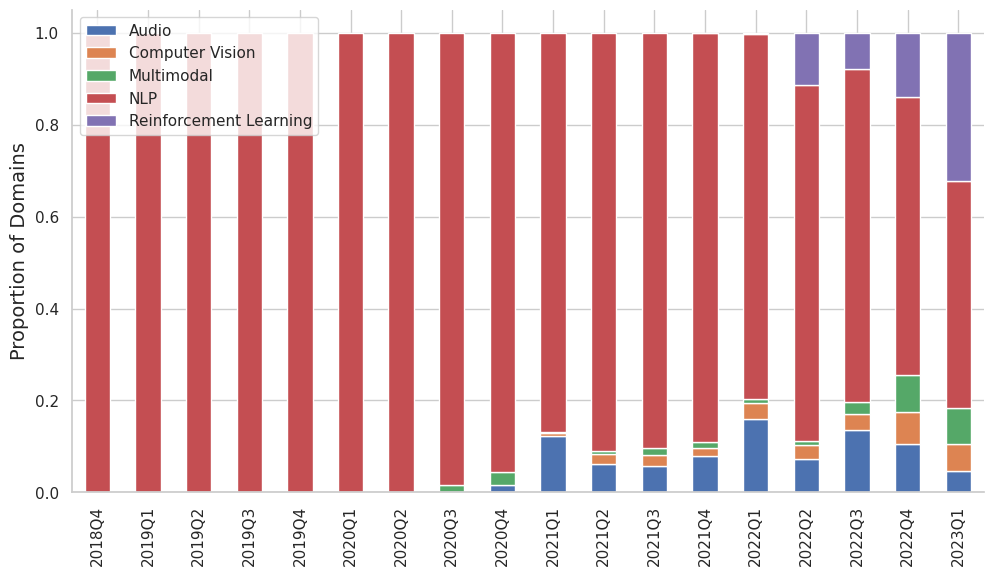

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create a 'period' column to group by every 3 months
df['created_at'] = pd.to_datetime(df['created_at'])
df['period'] = df['created_at'].dt.to_period('Q')


if latex:
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })

# Calculate domain counts for each period
domain_counts = df.groupby('period')['domain'].apply(lambda x: x.explode().value_counts()).unstack(fill_value=0)[1:-1]

# Normalize the counts to get proportions
domain_proportions = domain_counts.div(domain_counts.sum(axis=1), axis=0)
# Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(set_size(850)[0], set_size(850)[1]-1))
domain_proportions.plot(kind='bar', stacked=True, ax=ax)
ax.set_ylabel('Proportion of Domains',fontsize=14)
# ax.set_title('Evolution of Domain Proportions Every 3 Months')
ax.set_xlabel(None)
plt.legend(loc='upper left')


sns.despine()

plt.savefig('model_domains_evolution.pdf',  bbox_inches='tight')
plt.show()


#### Most Popular Tags

In [14]:
def remove_prefix(tags):
    return [tag[3:] for tag in tags]

In [15]:
# Sum the values of each one-hot encoded column
tag_counts = df.iloc[:,30:].sum(axis=0)

# Convert the counts to a DataFrame and reset the index
tag_counts_df = tag_counts.to_frame(name='count').reset_index()

# Rename the columns for better readability
tag_counts_df.columns = ['tag', 'count']

# Ensure the 'count' column contains only numeric values
tag_counts_df['count'] = pd.to_numeric(tag_counts_df['count'], errors='coerce')

# Sort the DataFrame by the count in descending order
tag_counts_df = tag_counts_df.sort_values(by='count', ascending=False)

# Display the top N most frequent tags 
N = 15
print(tag_counts_df.head(N))

                               tag    count
81                 is_transformers  83566.0
58                      is_pytorch  80567.0
54                       is_no-tag  55986.0
6          is_autotrain_compatible  33487.0
73                  is_tensorboard  29963.0
46                  is_model-index  24230.0
29       is_generated_from_trainer  21168.0
8                          is_bert  19523.0
74          is_text-classification  19468.0
60       is_reinforcement-learning  17161.0
77         is_text2text-generation  14113.0
19  is_deep-reinforcement-learning  11782.0
75              is_text-generation  11636.0
30                         is_gpt2  10162.0
38                          is_jax   8159.0


/tmp/ipykernel_23512/3639922663.py:2: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  tag_counts = df.iloc[:,30:].sum(axis=0)


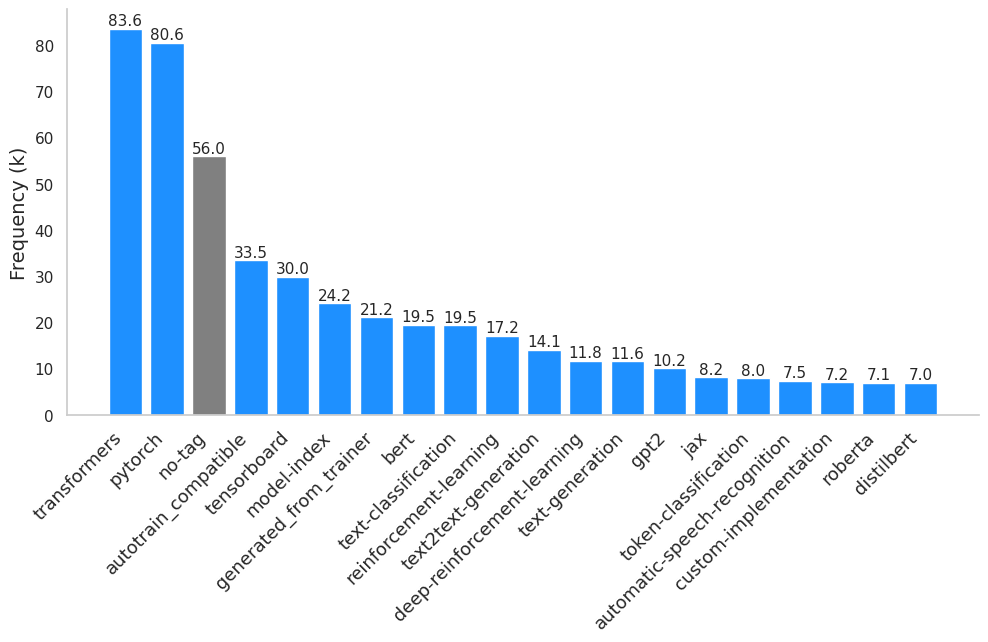

In [19]:
import matplotlib.pyplot as plt

# Assuming 'tag_counts_df' contains the sorted tag counts

# Display the top N most frequent tags (change N to your desired number)
N = 20
top_tags = tag_counts_df.head(N)

if latex:
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })

# Create a bar chart
fig, ax = plt.subplots(figsize=(set_size(850)[0], set_size(850)[1]-2))

# Create a color list with 'dodgerblue' as the default color for all bars
colors = ['dodgerblue'] * N

# Find the index of the 'no-tag' bar and set its color to gray
no_tag_index = top_tags['tag'].tolist().index('is_no-tag')
colors[no_tag_index] = 'gray'

ax.bar(remove_prefix(top_tags['tag']), top_tags['count']/1000, color=colors)

# Set labels and title
ax.set_ylabel('Frequency (k)', fontsize=14)
ax.set_xlabel(None)

# Rotate the x-axis labels to improve readability
plt.xticks(rotation=45, ha='right', fontsize=13)

# Function to format numbers (e.g., 85000 -> 85k)
def format_number(num):
    if num >= 1000000:
        return '{:.1f}M'.format(num / 1000000)
    elif num >= 1000:
        return '{:.1f}'.format(num / 1000)
    else:
        return '{:.1f}'.format(num)
# Annotate bars with counts
for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(
        format_number(height),
        (rect.get_x() + rect.get_width() / 2, height),
        ha='center',
        va='bottom',
        fontsize=11,
    )

ax.grid(False)
sns.despine()


# Display the chart
plt.savefig('most_frequent_tags.pdf',  bbox_inches='tight')
plt.show()


# p-values

In [17]:
from statsmodels.stats.multitest import multipletests

In [17]:
pvalues_and_text = ['0.06421025271260412 -> slope reporting co2',
                    '0.0010268592930073807 -> slope reported co2',
                    '0.9259196067684714 -> accuracy autotrain',
                    '0.6916077268076143 -> f1 autotrain',
                    '0.7712600666419309 -> rouge 1 autotrain',
                    '0.4377329988626998 -> rougeL autotrain',
                    '0.41714143714253127 -> accuracy clean',
                    '0.3178226816985236 -> f1 clean',
                    '0.4820720382996776 -> rouge 1 clean',
                    '1 -> rougeL clean',
                    '0.02920509534997118 -> pretraining vs finetuning',
                    '3.294350083195913e-05 -> log(co2e) - log(model size)',
                    '4.190761324292362e-05 -> log(co2e) - log(data size):',
                    '1.1409164876282704e-15 -> domain analysis']

pvalues = [float(pvalue_and_text.split(' -> ')[0]) for pvalue_and_text in pvalues_and_text]
pvalues_context = [pvalue_and_text.split(' -> ')[1] for pvalue_and_text in pvalues_and_text]

In [18]:
_, pvals_corrected, _, _ = multipletests(pvalues, method='holm')

In [19]:
[(pvalcorrected, context) for pvalcorrected, context in zip(pvals_corrected, pvalues_context)]

[(0.5778922744134372, 'slope reporting co2'),
 (0.011295452223081188, 'slope reported co2'),
 (1.0, 'accuracy autotrain'),
 (1.0, 'f1 autotrain'),
 (1.0, 'rouge 1 autotrain'),
 (1.0, 'rougeL autotrain'),
 (1.0, 'accuracy clean'),
 (1.0, 'f1 clean'),
 (1.0, 'rouge 1 clean'),
 (1.0, 'rougeL clean'),
 (0.29205095349971183, 'pretraining vs finetuning'),
 (0.0004282655108154687, 'log(co2e) - log(model size)'),
 (0.0005028913589150835, 'log(co2e) - log(data size):'),
 (1.5972830826795786e-14, 'domain analysis')]